In [1]:
import pandas as pd
import importlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter
from matplotlib import colors
from spatialentropy import altieri_entropy
from datetime import date
import time
import sys
from fears.population import Population
sys.path.append("./utils")
from DoseResponseModel import DoseResponseModel

In [2]:
p = Population(death_model = None,n_allele=2,fitness_data='random')
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

def get_most_fit_at_conc(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = p.gen_fit_land(conc)
            most_fit_at_conc[z,j] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

def estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False):
    msw_entropy = []
    pop_entropy = []
    msw_count = []
    pop_count = []
    # consumpt_rate_list = []
    for i,rate in enumerate(consumpt_rate):
        dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
        diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
        diffGrid = pd.read_csv(diffGridFile)
        msw_list = get_most_fit_at_conc_1d(np.array(diffGrid['field']))
        msw_list = np.array(msw_list, dtype=int)
        points = np.array(diffGrid[['x','y']])
        e_msw = altieri_entropy(points, msw_list)
        
        for j in range(n_replicates):
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
            popGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
            popGrid = pd.read_csv(popGridFile)
            points = np.array(popGrid[['x','y']])
            types = np.array(popGrid['genotype'])
            e_pop = altieri_entropy(points, types)
            pop_entropy.append(e_pop.entropy)
            msw_entropy.append(e_msw.entropy)
            # consumpt_rate_list.append(rate)
            for g in range(4):
                msw_count.append(np.sum(msw_list==g))
                pop_count.append(np.sum(types==g))

            if debug and j == 0:
                # plot exemplary sims
                fig,ax_list = plt.subplots(ncols=2,figsize=(10,5))
                msw_img = np.zeros((100,100))
                pop_img = np.zeros((100,100))
                for index,row in popGrid.iterrows():
                    x,y = row['x'],row['y']
                    pop_img[int(row['x']),int(row['y'])] = row['genotype']
                for index,row in diffGrid.iterrows():
                    if row['field'] > 0:
                        msw_img[int(row['x']),int(row['y'])] = row['field']
                msw_img = get_most_fit_at_conc(msw_img)
                cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
                cc_dict = cc.by_key()
                c = cc_dict['color']

                indx = list(set(msw_img.flatten()))
                indx = [int(i) for i in indx]
                c = [c[i] for i in indx]

                cmap = colors.ListedColormap(c)
                ax_list[0].imshow(msw_img,cmap=cmap)
                ax_list[1].imshow(pop_img,cmap=cmap)

    # compute correlation
    msw_entropy = np.array(msw_entropy)
    pop_entropy = np.array(pop_entropy)
    msw_count = np.array(msw_count)
    pop_count = np.array(pop_count)
    # entropy_res = stats.linregress(msw_entropy,pop_entropy)
    square_deviation = np.sum((msw_entropy-pop_entropy)**2)/np.sum(msw_entropy)
    nonzero_indx = np.logical_and(msw_count>0,pop_count>0)
    area_res = stats.linregress(np.log(msw_count[nonzero_indx]),np.log(pop_count[nonzero_indx]))
    # return entropy_res, area_res
    if debug:
        fig,ax_list = plt.subplots(ncols=2)
        ax = ax_list[0]
        ax.scatter(np.log(msw_count[nonzero_indx]),np.log(pop_count[nonzero_indx]))
        ax.plot(np.log(msw_count[nonzero_indx]),area_res.slope*np.log(msw_count[nonzero_indx])+area_res.intercept)
        ax.set_xlabel('log(MSW count)')
        ax.set_ylabel('log(Population count)')
        ax = ax_list[1]
        ax.scatter(msw_entropy,pop_entropy)
        # ax.plot(msw_entropy,entropy_res.slope*msw_entropy+entropy_res.intercept)
        ax.set_xlabel('MSW entropy')
        ax.set_ylabel('Population entropy')
        fig.tight_layout()
    return area_res, square_deviation

In [3]:
# setup parameter sweep

# mutation_rates = np.logspace(-5, -1, 5)
# mutation_rates = np.append(mutation_rates, 0.0)
mutation_rates = np.logspace(-5, -1, 5)
# mutation_rates = [0.001]
mutation_rates = np.append(0,mutation_rates)

init_mutant = np.logspace(-5, -1, 5)
init_mutant = np.append(0,init_mutant)

# consumpt_rate = [10**-4,0.001,0.01,0.1]
consumpt_rate = [0.001,0.01]

n_replicates = 1

jarFileName = "./HAL_dose_response.jar"
imgDir = "./tmp/"
today = date.today()
date_str = today.strftime("%Y-%m-%d")
data_folder = "./data/sensitivity_analysis_" + date_str

modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':2000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":None,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True}

total_sims = len(mutation_rates)*len(init_mutant)*len(consumpt_rate)*n_replicates
sim_count = 0

entropy_res_dict = {}
area_res_dict = {}

for r_m in mutation_rates:
    for i_m in init_mutant:
        indx = 0
        # st = time.time()
        for cr in consumpt_rate:
            modelConfigDic['consumpRate'] = cr
            modelConfigDic['pMutant'] = i_m
            modelConfigDic['mutProb'] = r_m
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
            myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
            myModel.Simulate()
            indx += 1
            sim_count += 1

        ar,er = estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False)
        # print('\n')
        # res_dict[(r_m,i_m)] = ar
        entropy_res_dict[(r_m,i_m)] = er
        area_res_dict[(r_m,i_m)] = ar
        # print('Mutation rate: {}'.format(r_m))
        # print('Initial mutant: {}'.format(i_m))
        # print(er)
        # print(ar)
        # elapsed = time.time() - st
        # time_remaining = (total_sims - sim_count)*elapsed
        # print('\n')
        # print("Estimated time remaining: {} seconds".format(np.round(time_remaining)))

        

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


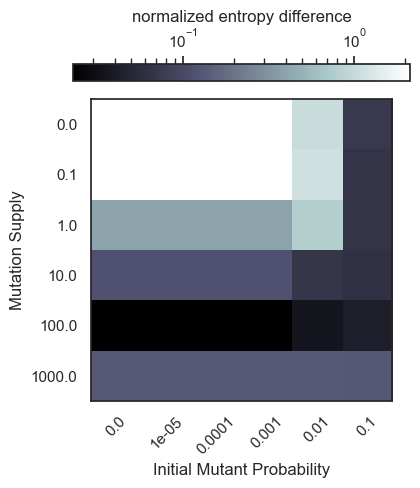

In [4]:
# slope_mat = np.zeros((len(mutation_rates),len(init_mutant)))
# p_mat = np.zeros((len(mutation_rates),len(init_mutant)))
entropy_map = np.zeros((len(mutation_rates),len(init_mutant)))
# for i in range(len(mutation_rates)):
#     for j in range(len(init_mutant)):
#         r_mat[i,j] = res_dict[(mutation_rates[i],init_mutant[j])].rvalue
#         p_mat[i,j] = res_dict[(mutation_rates[i],init_mutant[j])].pvalue
for key in entropy_res_dict.keys():
    mut_indx = np.argwhere(np.array(mutation_rates) == key[0])[0][0]
    init_indx = np.argwhere(np.array(init_mutant) == key[1])[0][0]
    entropy_map[mut_indx,init_indx] = entropy_res_dict[key]
    # p_mat[mut_indx,init_indx] = entropy_res_dict[key]

# fig,ax_list = plt.subplots(ncols=2,figsize=(9,5))

# ax = ax_list[0]

# slope_mat_log = np.log10(slope_mat)

fig,ax = plt.subplots(figsize=(6,5))

# im0 = ax.imshow(slope_mat_log,cmap='viridis_r')

# ax =  ax_list[1]
norm = colors.LogNorm(vmin=entropy_map.min(), vmax=entropy_map.max())
im = ax.imshow(entropy_map,cmap='bone',norm=norm)
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(mutation_rates)))
mutation_supply = np.array(mutation_rates)*10**4
ax.set_yticklabels(mutation_supply)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Mutation Supply')

# make colorbars
fig.colorbar(im,ax=ax,shrink=0.6,label='normalized entropy difference',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.7,label='normalized error',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.5)

fig.tight_layout()
fig.savefig('figures/sensitivity_analysis.png',dpi=300)
mut_rate_vs_init_mut_data = entropy_map


# Sensitivity analysis: blood vessel distance and initial mutant proportion

In [5]:
init_mutant = np.logspace(-5, -1, 5)
# init_mutant = np.array([0.1])
init_mutant = np.append(0,init_mutant)

# consumpt_rate = [10**-4,0.001,0.01,0.1]
consumpt_rate = [0.001,0.01]
vessel_sep = [30,40,50,60,70]

n_replicates = 10

jarFileName = "./HAL_dose_response.jar"
imgDir = "./tmp/"
today = date.today()
date_str = today.strftime("%Y-%m-%d")
data_folder = "./data/sensitivity_analysis_" + date_str

modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':2000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":None,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                    "vesselSep":50}

# total_sims = len(mutation_rates)*len(init_mutant)*len(consumpt_rate)*n_replicates
sim_count = 0

entropy_res_dict = {}
area_res_dict = {}

for v_s in vessel_sep:
    for i_m in init_mutant:
        indx = 0
        # st = time.time()
        for cr in consumpt_rate:
            modelConfigDic['consumpRate'] = cr
            modelConfigDic['pMutant'] = i_m
            modelConfigDic['vesselSep'] = v_s
            # modelConfigDic['mutProb'] = r_m
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
            myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
            myModel.Simulate()
            indx += 1
            sim_count += 1

        ar,er = estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False)
        entropy_res_dict[(v_s,i_m)] = er


        

30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
5

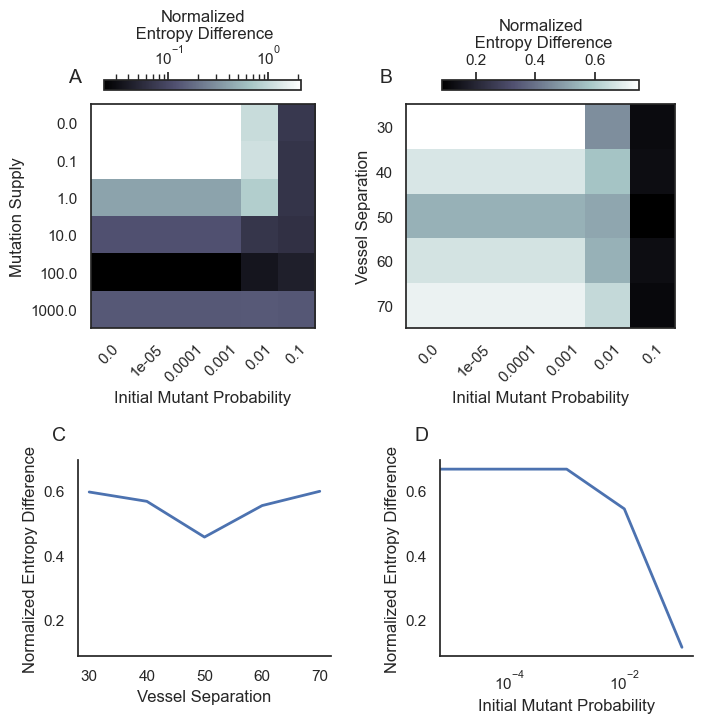

In [37]:
ent_map = np.zeros((len(vessel_sep),len(init_mutant)))

for key in entropy_res_dict.keys():
    vessel_indx = np.argwhere(np.array(vessel_sep) == key[0])[0]
    init_indx = np.argwhere(np.array(init_mutant) == key[1])[0]
    ent_map[vessel_indx,init_indx] = entropy_res_dict[key]
    # p_mat[mut_indx,init_indx] = entropy_res_dict[key]

# fig,ax_list = plt.subplots(ncols=2,figsize=(9,5))

# ax = ax_list[0]

# slope_mat_log = np.log10(slope_mat)

# fig,ax_list = plt.subplots(figsize=(6,5))
# fig, axd = plt.subplot_mosaic([['upper left', 'upper right'],
                            #    ['lower','lower']],
                            #   figsize=(5.5, 3.5))

fig,ax_list = plt.subplots(ncols=2,nrows=2,figsize=(8,8))

# im0 = ax.imshow(slope_mat_log,cmap='viridis_r')

# ax =  ax_list[1]
# norm = colors.LogNorm(vmin=ent_map.min(), vmax=ent_map.max())
# im = ax.imshow(ent_map,cmap='bone',norm=norm)
ax = ax_list[0,0]

norm = colors.LogNorm(vmin=entropy_map.min(), vmax=entropy_map.max())
im = ax.imshow(entropy_map,cmap='bone',norm=norm)
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(mutation_rates)))
mutation_supply = np.array(mutation_rates)*10**4
ax.set_yticklabels(mutation_supply)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Mutation Supply')

# make colorbars
ax.set_aspect(1)
fig.colorbar(im,ax=ax,shrink=0.7,label='Normalized\n Entropy Difference',location='top')

ax = ax_list[0,1]
im = ax.imshow(ent_map,cmap='bone')
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(vessel_sep)))
ax.set_yticklabels(vessel_sep)
# mutation_supply = np.array(mutation_rates)*10**4
# ax.set_yticklabels(mutation_supply)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Vessel Separation')
# ax.set_ylabel('Mutation Supply')

fig.colorbar(im,ax=ax,shrink=0.7,label='Normalized\n Entropy Difference',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.7,label='normalized error',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.5)

bv_diff = np.mean(ent_map,axis=1)
mut_prob_diff = np.mean(ent_map,axis=0)

ax = ax_list[1,0]
ax.plot(vessel_sep,bv_diff,linewidth=2)
ax.set_ylabel('Normalized Entropy Difference',fontsize=12)
ax.set_xlabel('Vessel Separation')

ax = ax_list[1,1]
ax.plot(init_mutant,mut_prob_diff,linewidth=2)
ax.set_xscale('log')
ax.set_ylabel('Normalized Entropy Difference',fontsize=12)
ax.set_xlabel('Initial Mutant Probability')

ymin = np.min([ax.get_ylim()[0] for ax in ax_list[1,:]])
ymax = np.max([ax.get_ylim()[1] for ax in ax_list[1,:]])

for ax in ax_list[1,:]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([ymin,ymax])

# shrink lower axes by 10%
pos = ax_list[1,0].get_position() # get the original position
pos2 = [pos.x0, pos.y0, pos.width*0.9, pos.height*0.7]
ax_list[1,0].set_position(pos2) # set a new position

pos = ax_list[1,1].get_position() # get the original position
pos2 = [pos.x0, pos.y0, pos.width*0.9, pos.height*0.7]
ax_list[1,1].set_position(pos2) # set a new position

# # move lower axes right and up
pos1 = ax_list[1,0].get_position() # get the original position
pos2 = [pos1.x0 + 0.02, pos1.y0 + 0.01,  pos1.width, pos1.height]
ax_list[1,0].set_position(pos2) # set a new position

pos1 = ax_list[1,1].get_position() # get the original position
pos2 = [pos1.x0 + 0.05, pos1.y0 + 0.01,  pos1.width, pos1.height]
ax_list[1,1].set_position(pos2) # set a new position

# add labels
ax_list[0,0].text(-0.1,1.1,'A',transform=ax_list[0,0].transAxes,fontsize=14)
ax_list[0,1].text(-0.1,1.1,'B',transform=ax_list[0,1].transAxes,fontsize=14)
ax_list[1,0].text(-0.1,1.1,'C',transform=ax_list[1,0].transAxes,fontsize=14)
ax_list[1,1].text(-0.1,1.1,'D',transform=ax_list[1,1].transAxes,fontsize=14)

fig.savefig('figures/sensitivity_analysis.pdf',dpi=300)
